## Version Description:
 * In this version - we predict just the __MTR Hole Diameter__ (`R600_HD`) in TZ6 using [Bayesian Neural Network Ensembling](https://github.com/TeaPearce/Bayesian_NN_Ensembles/blob/master/notebook_examples/keras_regression.ipynb?fbclid=IwAR245ooffs-UvrG1mtnnK55IfN1g03A5S-jgzW6Kqlk7LJzT9nbbIS27WuU) technique. 
 * Simulated data points synthesised from FDDN are used to train the ML model. 
 * The input features are `TZ_Flow` (_total zone flow_),`MIXP` (_Mixer pressure_),`AMBP` (_Ambient Pressure_),`AMBT` (_Ambient Temperature_) and the TZ6 CLR Restrictors.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

#Set some numpy print options for displaying numpy arrays to fit maximum width of cell
np.set_printoptions(precision=3, edgeitems=30, linewidth=1000,formatter=dict(float=lambda x: "%.6g" % x)) 
from functools import reduce

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn-whitegrid')

In [4]:
import warnings
warnings.filterwarnings("ignore")

### Loading Data

In [5]:
input_features = ['TZ_Flow','MIXP','AMBP','AMBT','R610_HS1','R611_HS1','R612_HS1','R613_HS1']
usecols = ['HoV']+input_features+['R600_HD']

In [6]:
FDDN_df = pd.read_csv('../../data/Simulation_dataset.csv', usecols = usecols)[usecols]
FDDN_df.head()

,HoV,TZ_Flow,MIXP,AMBP,AMBT,R610_HS1,R611_HS1,R612_HS1,R613_HS1,R600_HD
0,FDDN_ASD0,720.292743,1800,102926,297.15,131,136,120,120,146
1,FDDN_ASD1,871.403000,2600,102426,299.15,131,136,120,120,146
2,FDDN_ASD2,985.488429,3400,103127,294.15,131,136,120,120,146
3,FDDN_ASD3,722.824643,1800,101825,295.15,131,136,120,120,146
4,FDDN_ASD4,875.039489,2600,100523,295.15,131,136,120,120,146


In [7]:
LTR_df = pd.read_csv('../../data/LTR_dataset.csv', usecols = usecols)[usecols]
LTR_df.head()

,HoV,TZ_Flow,MIXP,AMBP,AMBT,R610_HS1,R611_HS1,R612_HS1,R613_HS1,R600_HD
0,A1,887.134249,2600.0000,101401.6000,299.386667,131,136,120,120,148
1,A2,886.764050,2600.0000,101576.3000,298.448667,131,136,120,120,149
2,A3,926.224856,2606.1928,102136.6035,297.109024,131,136,114,120,152
3,A4,915.139474,2599.8998,103195.6642,295.060027,131,136,120,120,154
4,A5,891.635528,2600.0000,102856.2000,294.755833,145,153,130,130,148


In [8]:
LTR_df['TZ_Flow'] = LTR_df['TZ_Flow'] * 0.8
LTR_df.head()

,HoV,TZ_Flow,MIXP,AMBP,AMBT,R610_HS1,R611_HS1,R612_HS1,R613_HS1,R600_HD
0,A1,709.707399,2600.0000,101401.6000,299.386667,131,136,120,120,148
1,A2,709.411240,2600.0000,101576.3000,298.448667,131,136,120,120,149
2,A3,740.979885,2606.1928,102136.6035,297.109024,131,136,114,120,152
3,A4,732.111579,2599.8998,103195.6642,295.060027,131,136,120,120,154
4,A5,713.308423,2600.0000,102856.2000,294.755833,145,153,130,130,148


### Scaling and Normalizing the Data:

In [9]:
from sklearn.preprocessing import MinMaxScaler
## Common MinMaxScaler for both input and output variables.
# scaler = MinMaxScaler()

## Separate MinMaxScaler for both input and output variables.
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler() 

In [10]:
# Rescale Data
df_rescaled = FDDN_df.copy()
df_rescaled.drop(columns=['HoV'],inplace = True) # Drop 'HoV' column as this column with categorical labels 

In [11]:
# Scale all columns with common scaler
# colnames_all = list(df_rescaled)
# df_rescaled[colnames_all] = scaler.fit_transform(df_rescaled[colnames_all])

# Scale input and output features using separate scalers
df_rescaled[input_features] = scaler_x.fit_transform(df_rescaled[input_features].astype(np.float))
df_rescaled[['R600_HD']] = scaler_y.fit_transform(df_rescaled[['R600_HD']].astype(np.float))

In [12]:
print('Rescaled Input Dataframe:')
df_rescaled

Rescaled Input Dataframe:


,TZ_Flow,MIXP,AMBP,AMBT,R610_HS1,R611_HS1,R612_HS1,R613_HS1,R600_HD
0,0.032273,0.0,0.899800,0.666667,0.481481,0.451613,0.50,0.50,0.0
1,0.360469,0.5,0.733356,1.000000,0.481481,0.451613,0.50,0.50,0.0
2,0.608250,1.0,0.966711,0.166667,0.481481,0.451613,0.50,0.50,0.0
3,0.037772,0.0,0.533289,0.333333,0.481481,0.451613,0.50,0.50,0.0
4,0.368367,0.5,0.099867,0.333333,0.481481,0.451613,0.50,0.50,0.0
5,0.627842,1.0,0.566578,0.333333,0.481481,0.451613,0.50,0.50,0.0
6,0.015393,0.0,0.933422,0.000000,0.481481,0.451613,0.20,0.50,0.0
7,0.358867,0.5,0.099867,0.333333,0.481481,0.451613,0.20,0.50,0.0
8,0.631416,1.0,0.566578,1.000000,0.481481,0.451613,0.20,0.50,0.0
9,0.048657,0.0,0.166778,0.833333,0.481481,0.451613,0.20,0.50,0.0


**Train BNN Ensemble with Simulation data from FDDN**

In [13]:
# Extract pandas dataframe values to numpy array
train_data= df_rescaled.values

# Separate arrays into input and output components (predictors and response variables)
x_train, y_train  = train_data[:,:-1] ,train_data[:,-1:]
print(x_train.shape, y_train.shape)

(1080, 8) (1080, 1)


### Bayesian Ensembling
 Bayesian Ensembling as the name suggests is an ensemble of '_n_' neural networks which is trained using the same training data, but the different predictions are used in finally computing a mean and standard deviation, so we get a confidence interval around the predictions.

In [14]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation

Using TensorFlow backend.


In [15]:
# BNN Ensemble Hyperparamters
n_ensemble = 10 # no. of NNs in ensemble
reg = 'anc'   # type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 40 # no. hidden units in NN
activation_in = 'tanh' # tanh relu sigmoid
data_noise = 0.001 # estimated noise variance
n_data = 6

# optimisation options
epochs = 200  # run reg for 15+ epochs seems to mess them up
l_rate = 0.001 # learning rate

# variance of priors
W1_var = 20/1  # 1st layer weights and biases
W_mid_var = 1/n_hidden # 2nd layer weights and biases
W_last_var = 1/n_hidden # 3rd layer weights    

In [16]:
# NN object
def fn_make_NN(reg='anc', activation_in='relu'):
    # get initialisations, and regularisation values
    W1_lambda = data_noise/W1_var
    W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[1,n_hidden])
    W1_init = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[1,n_hidden])

    b1_var = W1_var
    b1_lambda =  data_noise/b1_var
    b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
    b1_init = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])

    W_mid_lambda = data_noise/W_mid_var
    W_mid_anc = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])
    W_mid_init = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])

    b_mid_var = W_mid_var
    b_mid_lambda =  data_noise/b_mid_var
    b_mid_anc = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    b_mid_init = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    
    W_last_lambda = data_noise/W_last_var
    W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])
    W_last_init = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])

    # create custom regularised
    def custom_reg_W1(weight_matrix):
        if reg == 'reg':
            return K.sum(K.square(weight_matrix)) * W1_lambda/n_data
        elif reg == 'free':
            return 0.
        elif reg == 'anc':
            return K.sum(K.square(weight_matrix - W1_anc)) * W1_lambda/n_data

    def custom_reg_b1(weight_matrix):
        if reg == 'reg':
            return K.sum(K.square(weight_matrix)) * b1_lambda/n_data
        elif reg == 'free':
            return 0.
        elif reg == 'anc':
            return K.sum(K.square(weight_matrix - b1_anc)) * b1_lambda/n_data

    def custom_reg_W_mid(weight_matrix):
        if reg == 'reg':
            return K.sum(K.square(weight_matrix)) * W_mid_lambda/n_data
        elif reg == 'free':
            return 0.
        elif reg == 'anc':
            return K.sum(K.square(weight_matrix - W_mid_anc)) * W_mid_lambda/n_data

    def custom_reg_b_mid(weight_matrix):
        if reg == 'reg':
            return K.sum(K.square(weight_matrix)) * b_mid_lambda/n_data
        elif reg == 'free':
            return 0.
        elif reg == 'anc':
            return K.sum(K.square(weight_matrix - b_mid_anc)) * b_mid_lambda/n_data

    def custom_reg_W_last(weight_matrix):
        if reg == 'reg':
            return K.sum(K.square(weight_matrix)) * W_last_lambda/n_data
        elif reg == 'free':
            return 0.
        elif reg == 'anc':
            return K.sum(K.square(weight_matrix - W_last_anc)) * W_last_lambda/n_data

    model = Sequential()
    model.add(Dense(n_hidden, activation=activation_in, input_shape=(len(input_features),),
                    kernel_initializer=keras.initializers.Constant(value=W1_init),
                    bias_initializer=keras.initializers.Constant(value=b1_init),
                    kernel_regularizer=custom_reg_W1,
                    bias_regularizer=custom_reg_b1))

    model.add(Dense(n_hidden, activation=activation_in, 
                    kernel_initializer=keras.initializers.Constant(value=W_mid_init),
                    bias_initializer=keras.initializers.Constant(value=b_mid_init),
                    kernel_regularizer=custom_reg_W_mid,
                    bias_regularizer=custom_reg_b_mid))

    model.add(Dense(1, activation='linear',use_bias=False,
                    kernel_initializer=keras.initializers.Constant(value=W_last_init),
                    kernel_regularizer=custom_reg_W_last))

    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=l_rate))
    return model


def fn_predict_ensemble(NNs, x_test):
    ''' fn to predict given a list of NNs (an ensemble)''' 
    y_preds = []
    for m in range(len(NNs)):
        y_preds.append(NNs[m].predict(x_test, verbose=0))
    y_preds = np.array(y_preds)
#     y_preds_mu = np.mean(y_preds,axis=0)
#     y_preds_std = np.std(y_preds,axis=0)
#     return y_preds, y_preds_mu, y_preds_std
    return y_preds

In [17]:
# create the NNs
NNs=[]
for m in range(n_ensemble):
    NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))
print(NNs[-1].summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 40)                360       
_________________________________________________________________
dense_29 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 40        
Total params: 2,040
Trainable params: 2,040
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
%%time
# Do training with Simulation data
NNs_hist_train=[];
for m in range(n_ensemble):
    print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
    hist = NNs[m].fit(x_train,y_train,batch_size=n_data,epochs=epochs,verbose=0)
    NNs_hist_train.append(hist.history['loss'])

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --
Wall time: 5min 17s


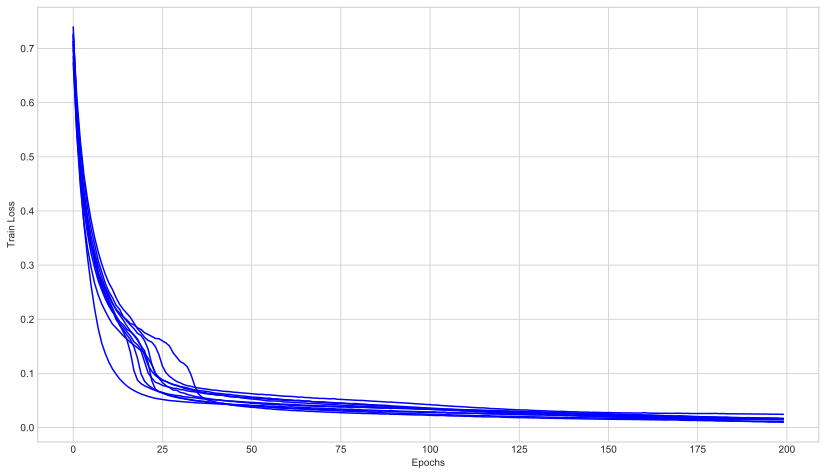

In [19]:
# check how Training Loss looked when training each NN in the ensemble
NNs_hist_train=np.array(NNs_hist_train)
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('Epochs')
ax.set_ylabel('Train Loss')
for m in range(n_ensemble):
    ax.plot(NNs_hist_train[m], color='b',label='train')

In [20]:
ax.figure.savefig('plots/BNN_Ensembling_v1_Train_Curves.svg')

### Make Predictions with LTR data

In [21]:
# Rescale LTR Data
LTR_df_rescaled = LTR_df.copy()
LTR_df_rescaled.drop(columns=['HoV'],inplace = True) # Drop 'HoV' column as this column with categorical labels 

# Scale input and output features using separate scalers
LTR_df_rescaled[input_features] = scaler_x.fit_transform(LTR_df_rescaled[input_features])
LTR_df_rescaled[['R600_HD']] = scaler_y.fit_transform(LTR_df_rescaled[['R600_HD']])
LTR_df_rescaled.head()

,TZ_Flow,MIXP,AMBP,AMBT,R610_HS1,R611_HS1,R612_HS1,R613_HS1,R600_HD
0,0.227805,0.254798,0.418091,0.949794,0.481481,0.451613,0.5,0.5,0.142857
1,0.223593,0.254798,0.474755,0.806945,0.481481,0.451613,0.5,0.5,0.214286
2,0.672487,0.394775,0.656491,0.602928,0.481481,0.451613,0.2,0.5,0.428571
3,0.546383,0.252533,1.000000,0.290882,0.481481,0.451613,0.5,0.5,0.571429
4,0.279010,0.254798,0.889894,0.244556,1.000000,1.000000,1.0,1.0,0.142857


In [22]:
LTR_X, y_true =  LTR_df_rescaled.iloc[:,:-1].values, LTR_df['R600_HD'].values
print(LTR_X.shape, y_true.shape)

(34, 8) (34,)


In [23]:
def output_reversescaler(predictions_scaled):
    '''Custom Function to Inverse Scale Predictions from BNN'''
    predictions = []
    for i in range(len(predictions_scaled)):
        data_scaled = predictions_scaled[i]
        data_unscaled = scaler_y.inverse_transform(data_scaled).ravel()
#         data_unscaled = np.concatenate(scaler_y.inverse_transform(data_scaled)).ravel().tolist()
        predictions.append(data_unscaled)
    return np.asarray(predictions)

In [24]:
# Make Predictions
y_preds_scaled = fn_predict_ensemble(NNs,LTR_X)
y_preds = output_reversescaler(y_preds_scaled)

In [25]:
print('Length of Y_Predictions:',len(y_preds))
print('Y_Predictions:')
print(y_preds[0:2],'...')

Length of Y_Predictions: 10
Y_Predictions:
[[146.553 146.545 164.378 163.558 149.045 151.783 149.064 166.599 167.933 148.711 160.187 169.554 158.286 147.1 145.508 147.006 137.925 140.238 148.975 145.499 158.637 147.812 170.998 160.356 167.849 142.415 153.453 167.396 151.614 158.212 165.759 168.828 140.041 149.381]
 [146.953 146.909 162.328 162.408 149.233 151.887 149.131 164.071 165.784 148.918 160.091 165.448 158.693 147.242 145.557 147.505 141.945 140.288 149.261 146.113 158.064 147.917 167.214 160.077 164.584 143.26 153.301 165.083 151.429 158.312 164.132 165.049 140.002 149.207]] ...


In [26]:
y_preds[0].shape

(34,)

In [27]:
# Manual Check of means of a random Column of y_preds array
x = []
for i in range(len(y_preds)):
    element = y_preds[i][0] # first index specifies array number, seconds index specifies the index of element inside the array
    x.append(element)
print('First Column elements:',x)
print('Mean:',np.mean(x))

First Column elements: [146.5526, 146.95317, 146.91718, 146.54834, 146.88985, 146.1342, 148.46591, 146.73628, 146.7621, 146.43391]
Mean: 146.83936


In [28]:
HoV_test_data = LTR_df['HoV'].values

y_mins = np.amin(y_preds,axis = 0) # axis = 0 computes measures across columns 
y_maxes = np.amax(y_preds, axis = 0 )
y_mu = np.mean(y_preds,axis = 0)
y_std = np.std(y_preds,axis = 0)

In [29]:
print('Length of Y_Predictions_Mu',len(y_mu))
print('No. of Test HoVs:',len(HoV_test_data),'\nHoVs of Test Points:',HoV_test_data)
print('\nTest Points-Org Y:', y_true)
print('\nY_Predictions_Mu:', y_mu)
print('\nY_Predictions_Std:', y_std)

Length of Y_Predictions_Mu 34
No. of Test HoVs: 34 
HoVs of Test Points: ['A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'D1' 'D2' 'E1' 'E2' 'F1' 'F2' 'F3' 'H1' 'I1' 'J1' 'M1' 'M2' 'P1' 'Q1' 'Q2' 'S1' 'S2' 'S3' 'S4' 'S5' 'T1' 'T2']

Test Points-Org Y: [148 149 152 154 148 148 148 153 152 150 152 154 151 148 148 148 146 146 148 148 152 148 154 154 154 148 148 155 148 150 150 160 148 148]

Y_Predictions_Mu: [146.839 146.827 163.92 163.645 149.192 151.863 149 165.07 166.921 148.898 160.231 167.656 158.626 147.41 145.753 147.084 140.383 140.232 149.259 145.827 158.182 147.879 170.696 160.319 166.608 141.976 153.388 166.189 151.536 158.186 165.386 168.141 140.171 149.405]

Y_Predictions_Std: [0.592654 0.589529 0.949118 0.72261 0.418874 0.331294 0.67916 1.46785 1.5928 0.398305 0.379627 2.23586 0.335735 0.657119 0.810743 0.197192 1.95378 1.96758 0.427478 0.665709 0.651637 0.903125 3.2051 0.423248 1.96327 2.11374 0.290279 1.48735 0.368494 0.338136 1.11988 2.8335 2.01218 0.460907]


### Plot BNN Predictions with Mean and Error Bars

In [30]:
from bokeh.models import CategoricalColorMapper,HoverTool,ColumnDataSource,Label,Range1d
from bokeh.plotting import figure, show, output_file,output_notebook
output_notebook()

Loading BokehJS ...

In [31]:
# create the coordinates for the errorbars
y_xs = []
ys_std = []
y_ys = []

for x, y_mean,std,min_dia, max_dia in zip(HoV_test_data,y_mu,y_std,y_mins,y_maxes):
    y_xs.append((x, x))
    ys_std.append((y_mean - std, y_mean + std))
    y_ys.append((y_mean - (y_mean - min_dia), y_mean + (max_dia - y_mean)))

In [32]:
# plot the points
f = figure(x_range=HoV_test_data, title='Bayesian Ensembling - Dia Predictions with Confidence Interval', width=1400)
dot_hover_tooltips = HoverTool(names=['DiaPoints'],tooltips=[("HoV","@x"),("Dia", "@y mm")])
whisker_hover_tooltips = HoverTool(names=['Whiskers'],tooltips=[("Dia", "@y mm")])
# multiline_hover_tooltips = HoverTool(names=['LinePlot'],tooltips=[("Dia", "$y mm")])

f.add_tools(dot_hover_tooltips)

f.xaxis.axis_label = 'Head of Versions'
f.yaxis.axis_label = 'Diameter Predictions (mm)'

f.multi_line(y_xs, ys_std, color='blue', line_width = 3, legend = 'Mean Prediction +/- Std.Dev')
f.multi_line(y_xs, y_ys, color='deepskyblue',name='LinePlot',legend = 'Mean Prediction +/- Min & Max Value')
f.diamond(HoV_test_data, y_true, color='red', size=12, line_alpha=0,name='DiaPoints', legend = 'True Dia')
f.circle(HoV_test_data, y_mu, color='blue', size=9, line_alpha=0,name='DiaPoints', legend = 'Predicted Dia (Mean)')

# whiskers (almost-0 height rects simpler than segments)
for i in range(len(y_xs)):
    f.rect(y_xs[i], y_ys[i], 0.2, 0.001, line_color="deepskyblue",name='Whiskers')

f.y_range=Range1d(135, 175)
f.legend.location = "top_center"
f.legend.click_policy="hide"
output_file('plots/BNN_Ensembling_v1_FDDN_LTR_Predictions.html', mode='inline')

In [33]:
show(f)

In [34]:
from bokeh.io import export_svgs
f.output_backend = "svg"
export_svgs(f, filename="plots/BNN_Ensembling_v1_FDDN_LTR_Predictions.svg")

['plots/BNN_Ensembling_v1_FDDN_LTR_Predictions.svg']